# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd

from vivace.backtest import (BacktestEngine, Strategy, Weighting, InstrumentDef,
                             Performance, signal, processing, rebase, PnLType)
from vivace.backtest.engine import long_only_returns

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

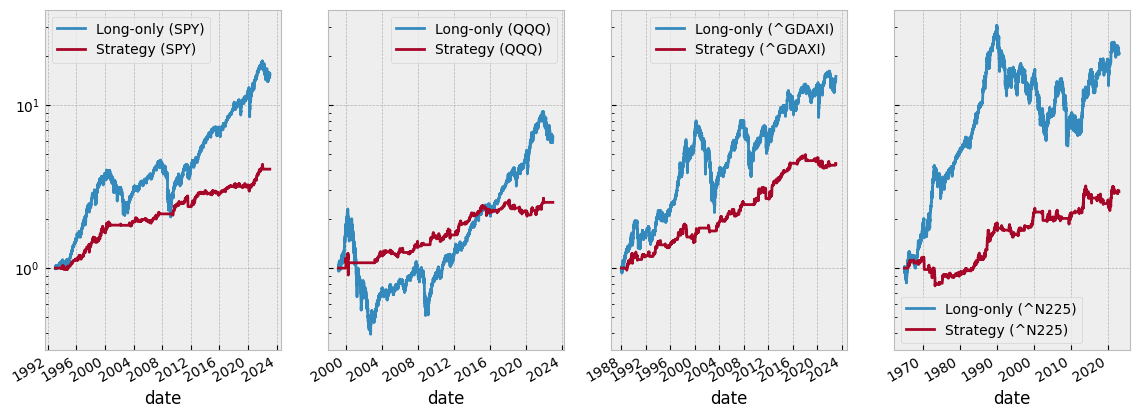

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.091679,0.046705,0.077638,0.039010,0.077086,0.041839,0.053581,0.019091
Annualised vol,0.189259,0.072443,0.277913,0.099236,0.222246,0.081708,0.201480,0.074913
Sharpe ratio,0.484409,0.644719,0.279360,0.393104,0.346851,0.512056,0.265938,0.254839
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.233963,0.818712,0.335098
Calmar ratio,0.166117,0.331817,0.093580,0.146665,0.106056,0.178827,0.065445,0.056971
Skewness,-0.055648,-0.837466,0.216588,1.630443,-0.115800,-1.859844,-0.184859,-3.326533
Kurtosis,11.295528,40.883408,6.743079,74.159377,6.433286,69.786575,8.774662,121.183505
Worst return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081137,-0.246190,-0.246190,-0.216097,-0.128878,-0.243342,-0.127345


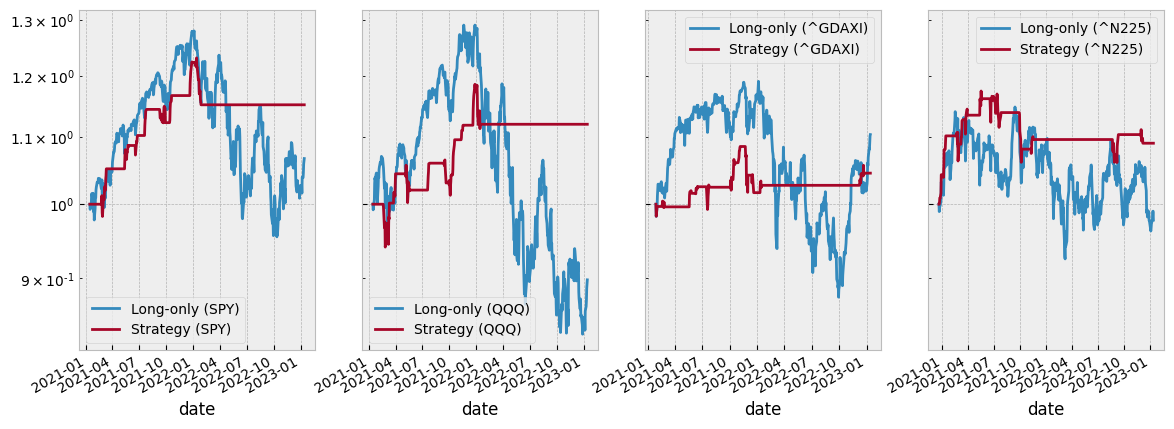

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

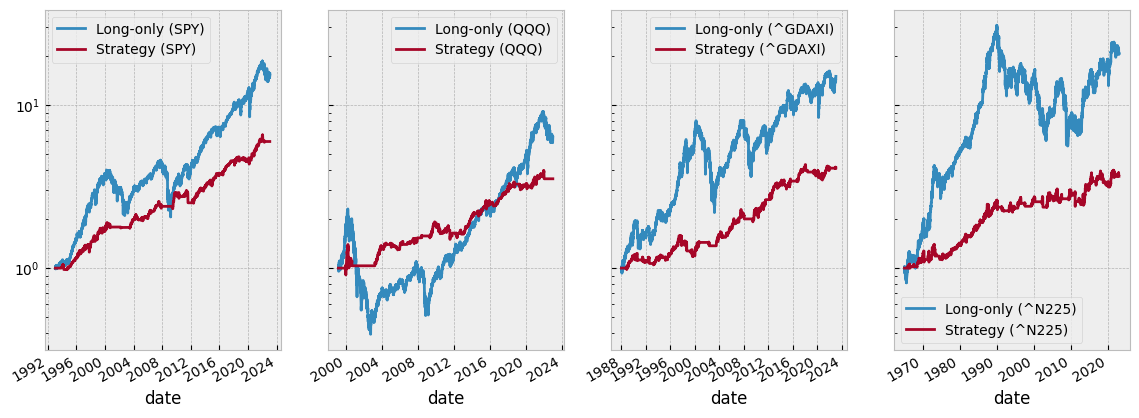

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.091679,0.059753,0.077638,0.052988,0.077086,0.040283,0.053581,0.022909
Annualised vol,0.189259,0.081830,0.277913,0.113308,0.222246,0.088155,0.201480,0.086759
Sharpe ratio,0.484409,0.730211,0.279360,0.467647,0.346851,0.456960,0.265938,0.264049
Max drawdown,0.551894,0.163106,0.829639,0.282275,0.726848,0.256756,0.818712,0.219014
Calmar ratio,0.166117,0.366344,0.093580,0.187718,0.106056,0.156894,0.065445,0.104600
Skewness,-0.055648,-0.605193,0.216588,0.789574,-0.115800,-0.218810,-0.184859,-2.463720
Kurtosis,11.295528,28.718386,6.743079,48.934591,6.433286,16.549323,8.774662,82.874934
Worst return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081137,-0.246190,-0.246190,-0.216097,-0.087830,-0.243342,-0.127345


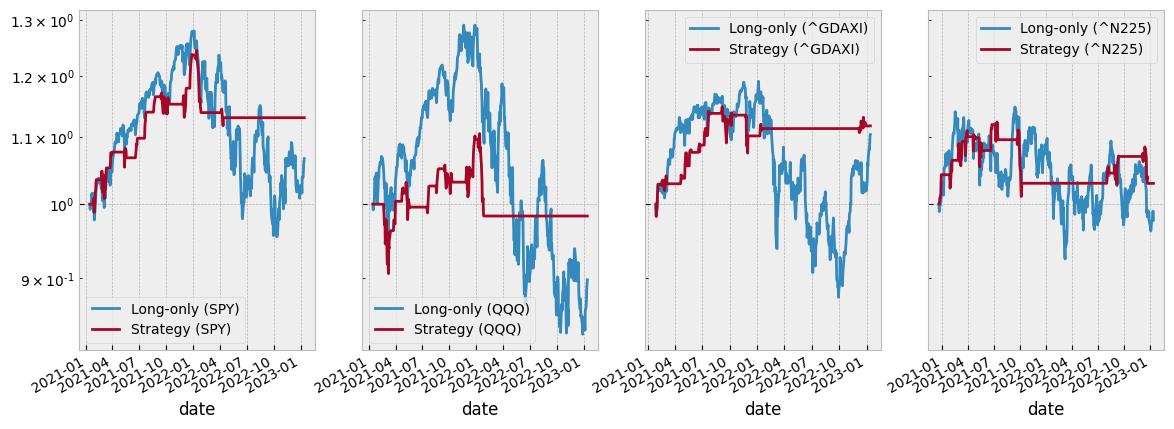

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

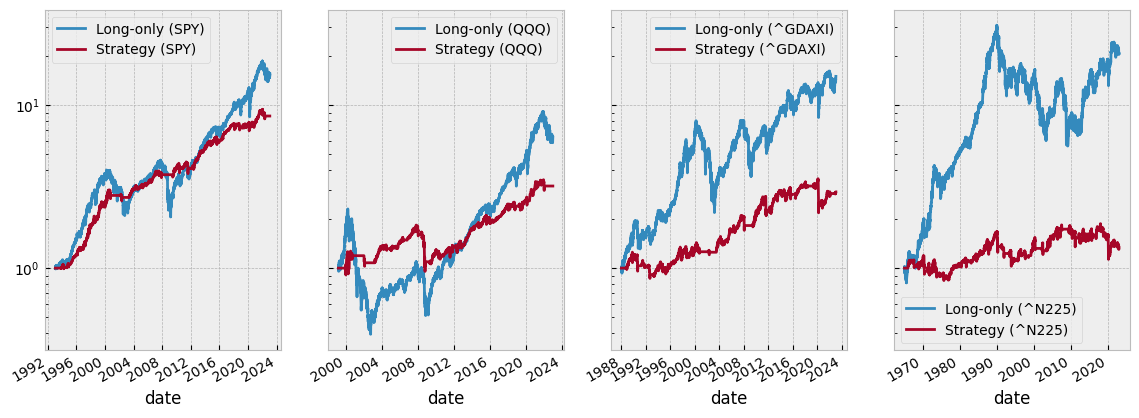

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.091679,0.071786,0.077638,0.048695,0.077086,0.030645,0.053581,0.005155
Annualised vol,0.189259,0.098223,0.277913,0.143651,0.222246,0.117492,0.201480,0.106038
Sharpe ratio,0.484409,0.730846,0.279360,0.338980,0.346851,0.260830,0.265938,0.048610
Max drawdown,0.551894,0.153226,0.829639,0.480136,0.726848,0.382193,0.818712,0.395910
Calmar ratio,0.166117,0.468498,0.093580,0.101419,0.106056,0.080183,0.065445,0.013019
Skewness,-0.055648,-0.309899,0.216588,0.663054,-0.115800,-1.217082,-0.184859,-1.629958
Kurtosis,11.295528,18.097724,6.743079,33.169332,6.433286,37.559216,8.774662,45.782001
Worst return,-0.109424,-0.072473,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.246190,-0.216097,-0.200123,-0.243342,-0.159939


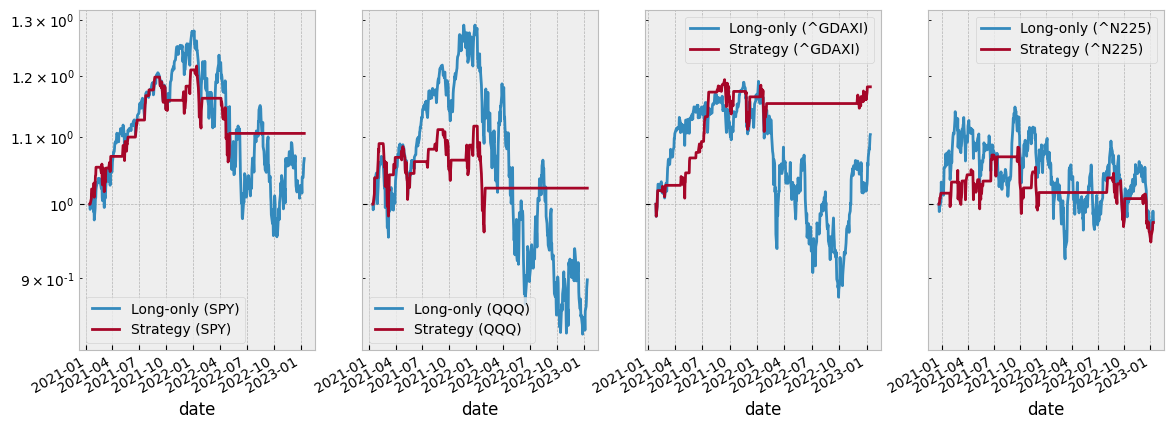

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

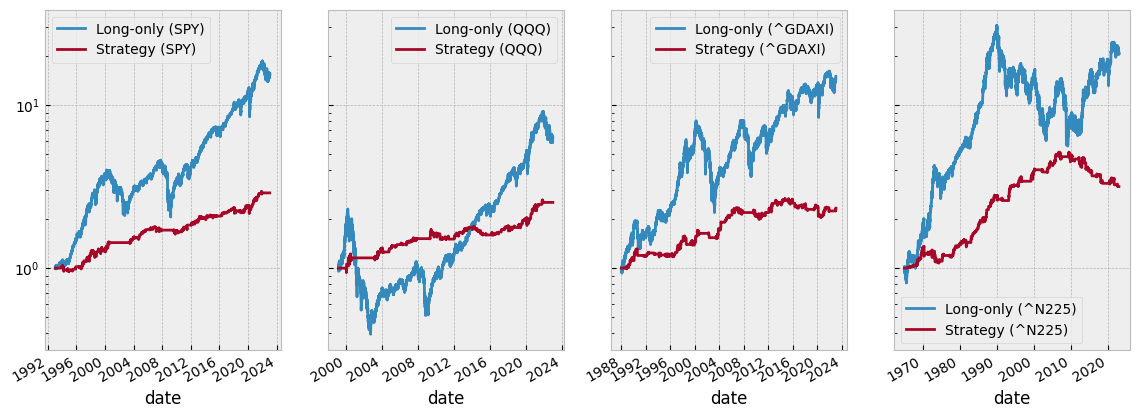

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.091679,0.035498,0.077638,0.038968,0.077086,0.024042,0.053581,0.020341
Annualised vol,0.189259,0.061752,0.277913,0.081054,0.222246,0.066230,0.201480,0.058405
Sharpe ratio,0.484409,0.574860,0.279360,0.480765,0.346851,0.363000,0.265938,0.348279
Max drawdown,0.551894,0.111611,0.829639,0.131615,0.726848,0.238856,0.818712,0.386113
Calmar ratio,0.166117,0.318056,0.093580,0.296075,0.106056,0.100653,0.065445,0.052682
Skewness,-0.055648,-0.792538,0.216588,0.439602,-0.115800,-0.258758,-0.184859,-1.819791
Kurtosis,11.295528,47.819789,6.743079,41.353345,6.433286,27.781017,8.774662,77.958494
Worst return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.106267,-0.216097,-0.124379,-0.243342,-0.127345


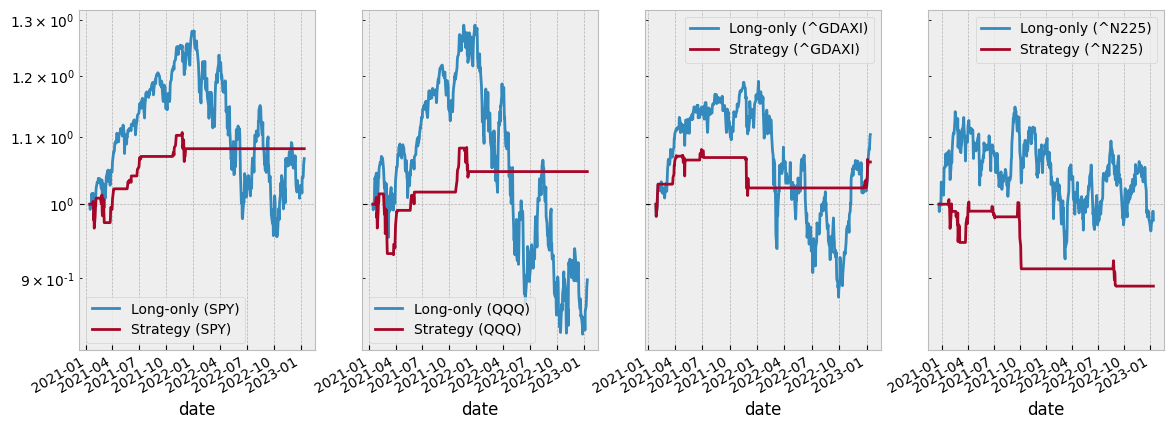

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 16-Jan-2023 07:19
